# Progresa Evaluation

## Introduction to the project

For this project, I used data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz.

The goal of this project is to implement some of the basic econometric techniques to measure the impact of Progresa on secondary school enrollment rates.

1. Descriptive analysis: Check the dataset's characteristics and baseline information.
2. Simple difference: Estimate the causal impact by simple difference, by tabular analysis and regression.
3. Difference-in-difference: Re-estimate the causal effect by Difference-in-Difference, the method which is more suitable for this dataset.

### The timeline of the program:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|
|grc97  |grade enrolled in 1997

---

## Part 1: Descriptive Analysis

### Data exploration

I check some statistics (mean, median and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village).

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Read progresa data
df = pd.read_csv('progresa_sample.csv')

# List of demographic variables (excluding 'year', 'folnum', 'village')
demographic_variables = df.columns.difference(['year', 'folnum', 'village'])

# Calculate summary statistics
summary_statistics = df[demographic_variables].describe().transpose()[['mean', '50%', 'std']]
# Rename '50%' column to 'median'
summary_statistics.rename(columns={'50%': 'median'}, inplace=True)

# Sort the table alphabetically by variable name
summary_statistics.sort_index(inplace=True)

# Display the summary statistics table
summary_statistics

,mean,median,std
age,11.366460,11.000000,3.167744
dist_cap,147.674452,132.001494,76.063134
dist_sec,2.418910,2.279000,2.234109
fam_n,7.215715,7.000000,2.352900
grc,3.963537,4.000000,2.499063
grc97,3.705372,4.000000,2.572387
hohage,44.436717,43.000000,11.620372
hohedu,2.768104,2.000000,2.656106
hohsex,0.925185,1.000000,0.263095
hohwag,586.985312,500.000000,788.133664


### Differences at baseline?

Next, I check the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages. I use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset.

In [3]:
# Filter for 1997 and poor households
df_base_poor = df[(df.year == 97) & (df.poor == 'pobre')]

# Distinguish between treatment and control groups
base_treatment = df_base_poor[df_base_poor.progresa == 'basal']
base_control = df_base_poor[df_base_poor.progresa == '0']

# List of variables to test, excluding identifiers and the 'progresa' column
variables = ['sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist', 'dist_cap', 'hohedu', 'hohwag', 'welfare_index', 'hohsex', 'hohage', 'age']

In [4]:
# Show the difference in table
# Initialize a list to store results
results = []

# Perform T-tests for each variable
for var in variables:
    base_treatment_mean = base_treatment[var].mean()
    base_control_mean = base_control[var].mean()
    diff = base_treatment_mean - base_control_mean
    
    # Perform T-test and obtain p-value
    t_stat, p_value = ttest_ind(base_treatment[var].dropna(), base_control[var].dropna(), equal_var=False)
    
    # Append results
    results.append([var, base_treatment_mean, base_control_mean, diff, p_value])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Variable name', 'Average value (Treatment villages)', 'Average value (Control villages)', 'Difference (Treat - Control)', 'p-value'])

# Sort results by variable name
results_df.sort_values('Variable name', inplace=True)

# Display the results
results_df.round(6)

,Variable name,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
13,age,10.716991,10.742023,-0.025032,0.478363
7,dist_cap,150.829074,153.769730,-2.940656,0.001146
2,dist_sec,2.453122,2.507662,-0.054540,0.042663
5,fam_n,7.281327,7.302469,-0.021142,0.428967
4,grc,3.531599,3.543050,-0.011450,0.689523
12,hohage,43.648828,44.276918,-0.628090,0.000002
8,hohedu,2.663139,2.590348,0.072791,0.010382
11,hohsex,0.924656,0.922947,0.001709,0.572125
9,hohwag,544.339544,573.163558,-28.824015,0.000329
1,indig,0.325986,0.332207,-0.006222,0.245902


#### Note

 * According to the resilt of t-test, not all the variables are statistically significant. If there is statistically significant different between treatment and control groups, the p-value should be less 0.05. Based on the rule, only dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, sc, sex and welfare_index are statistically significant.

 * The differences at baseline is to ensure the treatment and control villages are equivalent at the baseline. However, since there could be statistically significant differences between these two groups, we can't use single difference between treatment and control, or pre-post comparison that require 0 difference at baseline.

 * We need to choose the method and make sure the randomization in the experiment design that allows us to assume the difference in the treatment and control groups at baseline

### 1.4 Graphical exploration, part 1

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

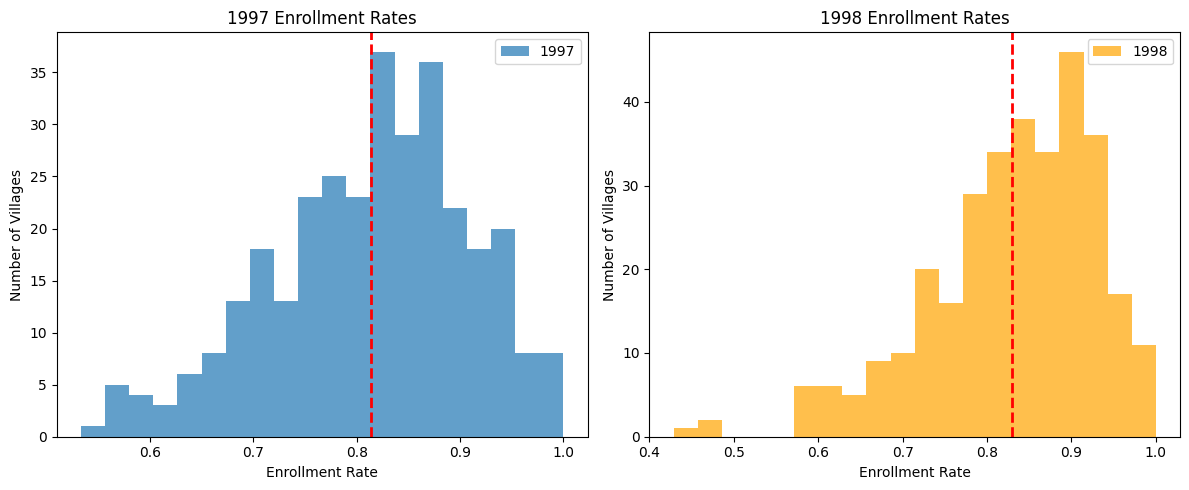

T-statistic: -3.2234841005787582, P-value: 0.0013973920121984071
0.015696793203423653


In [5]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Filter for treated villages and poor households
treatment = df[(df.progresa == 'basal') & (df.poor == 'pobre')]

# Calculate average enrollment rates by village and year
avg_treatment_enroll = treatment.groupby(['village', 'year'])['sc'].mean().reset_index()

# Separate the years for comparison
avg_treatment_enroll_base = avg_treatment_enroll[avg_treatment_enroll.year == 97]['sc']
avg_treatment_enroll_end = avg_treatment_enroll[avg_treatment_enroll.year == 98]['sc']

# Plot histograms
plt.figure(figsize=(12, 5))

# 1997 Enrollment Rates
plt.subplot(1, 2, 1)
plt.hist(avg_treatment_enroll_base, bins=20, alpha=0.7, label='1997')
plt.axvline(avg_treatment_enroll_base.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title('1997 Enrollment Rates')
plt.xlabel('Enrollment Rate')
plt.ylabel('Number of Villages')
plt.legend()

# 1998 Enrollment Rates
plt.subplot(1, 2, 2)
plt.hist(avg_treatment_enroll_end, bins=20, alpha=0.7, label='1998', color='orange')
plt.axvline(avg_treatment_enroll_end.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title('1998 Enrollment Rates')
plt.xlabel('Enrollment Rate')
plt.ylabel('Number of Villages')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical significance
t_stat, p_value = ttest_rel(avg_treatment_enroll_base, avg_treatment_enroll_end)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(avg_treatment_enroll_end.mean() - avg_treatment_enroll_base.mean())

After the intervention, the enrollment rate increased and the p-value is less than 0.05, which shows there is a statistically significant difference.

### 1.5 Graphical exploration, part 2

Repeat the above exercise for poor households in **control villages**, before and after treatment. Do you observe a difference in enrollment in control villages between 1997 and 1998? How does what you observe here affect how you might approach measuring the impact of PROGRESA?

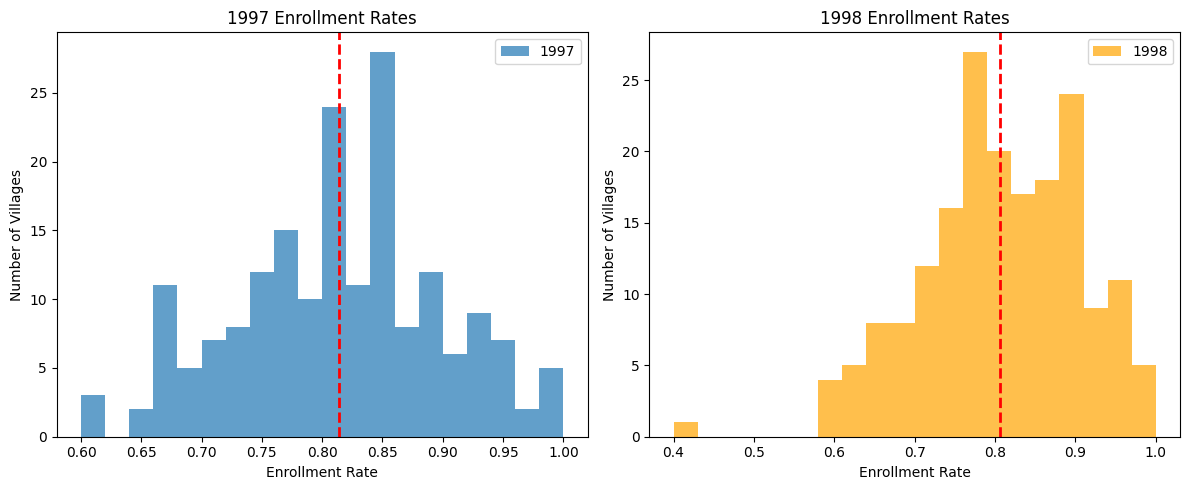

T-statistic: 1.355547718836688, P-value: 0.17690463958911543
-0.007591730456275592


In [6]:
# Filter for treated villages and poor households
control = df[(df.progresa == '0') & (df.poor == 'pobre')]

# Calculate average enrollment rates by village and year
avg_control_enroll = control.groupby(['village', 'year'])['sc'].mean().reset_index()

# Separate the years for comparison
avg_control_enroll_base = avg_control_enroll[avg_control_enroll.year == 97]['sc']
avg_control_enroll_end = avg_control_enroll[avg_control_enroll.year == 98]['sc']

# Plot histograms
plt.figure(figsize=(12, 5))

# 1997 Enrollment Rates
plt.subplot(1, 2, 1)
plt.hist(avg_control_enroll_base, bins=20, alpha=0.7, label='1997')
plt.axvline(avg_control_enroll_base.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title('1997 Enrollment Rates')
plt.xlabel('Enrollment Rate')
plt.ylabel('Number of Villages')
plt.legend()

# 1998 Enrollment Rates
plt.subplot(1, 2, 2)
plt.hist(avg_control_enroll_end, bins=20, alpha=0.7, label='1998', color='orange')
plt.axvline(avg_control_enroll_end.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title('1998 Enrollment Rates')
plt.xlabel('Enrollment Rate')
plt.ylabel('Number of Villages')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical significance
t_stat, p_value = ttest_rel(avg_control_enroll_base, avg_control_enroll_end)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(avg_control_enroll_end.mean() - avg_control_enroll_base.mean())

The enrollment rate decreases by 0.007591730456275592 and the p-value is more than 0.05, which shows there isn't a statistically significant difference in the controlled villages.

## Part 2: Simple Difference

My goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. I will focus on the impact of the program on school enrollment rates among the poor (those with poor=='pobre'), since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### Simple differences 1: T-test

Let's begin by estimating the impact of Progresa using "simple differences."
Simple difference is a very straight forward approach. We simple going to compare the outcomes of treatment and control group, or pre and post periods. This method is simple and easy to understand, but requires the strong assumption to generate unbiased estimate. Its underlying assumption is "The counterfactual assumption is that, in the absence of treatment, the average school enrollment in the treatment group and the average school enrollment in the control groups would have been the same." As we already saw there could be a selection bias between treatment and control group, so we need to keep in mind that this method will lead to biased estimation.

First, I calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages in 1998 (after treatment). Then, I use a t-test to determine if this difference is statistically significant.

In [7]:
# Filter for 1998 and poor households
df_end_poor = df[(df.year == 98) & (df.poor == 'pobre')]

# Separate into treatment and control groups
treatment_end = df_end_poor[df_end_poor.progresa == 'basal']
control_end = df_end_poor[df_end_poor.progresa != 'basal']

# Calculate average enrollment rates
avg_treatment_enroll_end = treatment_end['sc'].mean()
avg_control_enroll_end = control_end['sc'].mean()

# Perform T-test
t_stat, p_value = ttest_ind(treatment_end['sc'], control_end['sc'], nan_policy='omit')

print(f"Average enrollment rate in treatment villages: {avg_treatment_enroll_end}")
print(f"Average enrollment rate in control villages: {avg_control_enroll_end}")
print(f"Difference in average enrollment rates: {avg_treatment_enroll_end - avg_control_enroll_end}")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

Average enrollment rate in treatment villages: 0.8464791213954308
Average enrollment rate in control villages: 0.807636956730308
Difference in average enrollment rates: 0.0388421646651228
T-statistic: 8.358720567418374, P-value: 6.636344447378102e-17


#### Note

 * The p-value is nearly 0, way below 0.05, which means that the difference is statistically significant.

 * The difference of the average enrollment rate between treatment and control groups is 3.88%, indicating that Progresa is having a causal impact to the enrollment on the treatment villages.

### Simple differences 2: Regression

Now, let's estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates of the poor on treatment assignment.

In [8]:
# Data for regression
X = df_end_poor[['progresa', 'age', 'dist_sec', 'sex', 'hohedu', 'welfare_index', 'indig']]
X['progresa'] = X['progresa'].apply(lambda x: 1 if x == 'basal' else 0)  # Convert treatment to binary
X = sm.add_constant(X)  # Add a constant for the intercept term
y = df_end_poor['sc']  # Enrollment rate

# Fit the multiple regression model
model = sm.OLS(y, X, missing='drop').fit()  # OLS regression, dropping missing values

# Print the summary of the regression model
model.summary()

/Users/kaiting/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1419.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:54:19   Log-Likelihood:                -7639.4
No. Observations:               27267   AIC:                         1.529e+04
Df Residuals:                   27259   BIC:                         1.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5025      0.014    105.342      0.000       1.475       1.530
progresa          0.0352      0.004      8.799      0.000       0.027       0.043
age              -0.0655      0.001    -95.105      0.000      -0.067      -0.064
dist_sec         -0.0117      0.001    -13.361      0.000      -0.013      -0.010
sex               0.0310      0.004      7.977      0.000       0.023       0.039
hohedu            0.0085      0.001     10.951      0.000       0.007       0.010
welfare_index  3.227e-05   1.72e-05      1.872      0.061   -1.52e-06    6.61e-05
indig             0.0468      0.004     11.283      0.000       0.039       0.055
==============================================================================
Omnibus:                     2993.090   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4083.947
Skew:                          -0.940   Prob(JB):                         0.00
Kurtosis:                       3.248   Cond. No.                     4.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Note

* The enrollment rate would increase by 3.5% instead if the household receives Progresa.

* The p-value is very small (less than 0.05). Since the treatment effect remains statistically significant, we can reject the null hypothesis and states that the treatment effect is statistically significant.

## Part 3: Difference-in-Difference

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a **difference-in-differences (DID)** framework. The DID method is an approach to estimate causal effects under the selection bias between treatment and control group.


The underlying assumption of DID is, "there exist parallel trends over time in enrollment rates between treated and control villages." So it doesn't require the assumption Simple difference requires, which is "Treatment group and control group would have the same outcome in the absence of treatment." Although we need pre-period data to execute this method, this advantage on assumption is critical about impact evaluation in reality, especially because we already know there could be a selection bias between treatment and control group of this dataset.


### Difference-in-Difference 1: Tabular Analysis

Let's begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, I calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

In [9]:
# Filter for poor households
df_poor = df[df.poor == 'pobre']

# Create a pivot table for the average enrollment rates by year and treatment status
pivot_table = df_poor.pivot_table(values='sc', index='progresa', columns='year', aggfunc='mean')

# Calculate differences between years for control and treatment groups
pivot_table['diff'] = pivot_table[98] - pivot_table[97]

# Display the pivot table with differences
print(pivot_table)

# Calculate the Diff-in-Diff estimate
did_estimate = pivot_table.at['basal', 'diff'] - pivot_table.at['0', 'diff']

print(f"\nDifference-in-Difference Estimate: {did_estimate}")

year            97        98      diff
progresa                              
0         0.815186  0.807637 -0.007549
basal     0.822697  0.846479  0.023782

Difference-in-Difference Estimate: 0.031331280319323085


#### Note

* Focusing on poor, the difference-in-difference between 97 and 98 compare between the treatment and control villages is 0.0313, which is smaller than the result form simple difference. This helps us to assess whether treatment and control villages differed before Progresa.

* The counterfactual assumption is that in the absence of the Progresa, the difference in enrollment rates over time would have been the same for both treatment and control groups.

### Difference-in-Difference 2: Regression

Now I use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households.

In [10]:
# Create an interaction term for treatment and post
df['treatment'] = df['progresa'].apply(lambda x: 1 if x == 'basal' else 0).dropna(axis= 0)
df['post'] = df['year'].apply(lambda x: 1 if x == 98 else 0)
df['treatment_post'] = df['treatment'] * df['post']

In [11]:
# DiD regression with control variables
model_ii = smf.ols('sc ~ treatment + post + treatment_post + age + dist_sec + sex + hohedu + indig', 
                   data=df[(df['poor'] == 'pobre')]).fit()
model_ii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2810.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:54:19   Log-Likelihood:                -16717.
No. Observations:               58165   AIC:                         3.345e+04
Df Residuals:                   58156   BIC:                         3.353e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4940      0.006    231.606      0.000       1.481       1.507
treatment          0.0043      0.004      1.137      0.256      -0.003       0.012
post               0.0270      0.004      6.204      0.000       0.018       0.036
treatment_post     0.0314      0.006      5.685      0.000       0.021       0.042
age               -0.0655      0.000   -144.433      0.000      -0.066      -0.065
dist_sec          -0.0110      0.001    -17.788      0.000      -0.012      -0.010
sex                0.0339      0.003     12.672      0.000       0.029       0.039
hohedu             0.0076      0.001     14.110      0.000       0.007       0.009
indig              0.0496      0.003     17.304      0.000       0.044       0.055
==============================================================================
Omnibus:                     5523.777   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7269.312
Skew:                          -0.864   Prob(JB):                         0.00
Kurtosis:                       3.113   Cond. No.                         70.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Note

* The coefficient is  0.0314, indicating that the treatment village has 3.14% increase in enrollment rate after receiving Progresa. In the meantime, the standard error is 0.006. The results imply that there aren't many confounders affecting the treatment effect.

* Compared to the result of simple difference (3.5%), the DID estimator is smaller by 3.14%. This indicates the simple difference overestimated the causal effect of treatment possibly ue to the different ways these models account for other factors.


## Summary

* As long as standing with the assumption that the treatment group and control group have the same trend in the absence of the treatment, the double differences method can estimate an unbiased causal impact.

* The level of enrollment rates of comparably poor children in Progresa treatment villages are higher than in non-Progresa control villages when the Progresa program began offering educational grants to poor mothers whose children were enrolled in school. It is statistically significantly different from zero within each distinguished group of children who had completed grades 1 through 6 in the previous year. These differences are often larger for girls than boys. 

* According to DID regression, we can claim that the Progresa had a causal impact on the enrollment rates of poor households, by 3.14%.

* Other methods, such as simple differences, have some flaws in their underlying assumptions and thus overestimated the causal impact up 3.5%

* The randomization of assignment to the Progresa program is tested by calculating the differences in enrollment by the poor in the treated and control villages before the program started. These pre-program differences were not significant, suggesting that the implementation of the random assignment was performed successfully. It is really important to be aware of the underlying assumption of the method we use, and the limitation of perfect random assignment.